## pulizia file 

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
false = pd.read_csv("/home/federica/LAB2/nuovo/uniprot_false.tsv", sep="\t", low_memory=False)
true = pd.read_csv("/home/federica/LAB2/nuovo/uniprot_true.tsv", sep="\t", low_memory=False)

In [3]:
columns_to_keep = ['Entry',	'Reviewed',	'Entry Name','Protein names','Gene Names','Organism','Protein families', 'Natural variant','CDD','DisProt',
                   'Reactome', 'Interacts with','Subunit structure','Gene Names (primary)','Organism (ID)','Gene Names (synonym)','Involvement in disease',
                   'Pharmaceutical use','ChEMBL','DrugBank','BindingDB','DrugCentral', 'Mutagenesis']
true = true[columns_to_keep]
false = false[columns_to_keep]

In [4]:

def process_involvement_in_disease(text):
    if pd.isna(text) or text.startswith("Note: "):
        return None
    diseases = []
    matches = re.findall(r"DISEASE: (.+?) \[MIM:\d+\]", text)
    for match in matches:
        diseases.append(match.strip())
    return "; ".join(diseases) if diseases else None


In [5]:
true["Involvement in disease"] = true["Involvement in disease"].apply(process_involvement_in_disease)
false["Involvement in disease"] = false["Involvement in disease"].apply(process_involvement_in_disease)

In [6]:
def process_natural_variant(variant_string):
    if not isinstance(variant_string, str):
        return None
    matches = re.findall(r'VARIANT (\d+); /note="(\w) -> (\w) \(in (.+?)\)";', variant_string)
    results = []
    
    for match in matches:
        position = match[0]
        from_aa = match[1]
        to_aa = match[2]
        info = match[3]
        dbsnp_match = re.search(r'dbSNP:[^;]+', info)
        if dbsnp_match:
            dbsnp_info = dbsnp_match.group(0)
            info = info.replace(dbsnp_info, '').strip()
        result = f"{from_aa}{position}{to_aa}: {info}"
        results.append(result.strip(': '))
    
    return '-'.join(results)

In [7]:
true["Natural variant"] = true["Natural variant"].apply(process_natural_variant)
false["Natural variant"] = false["Natural variant"].apply(process_natural_variant)

In [8]:
def process_mutagenesis(text):
    if pd.isna(text):
        return None
    mutagenesis_data = []
    pattern = re.compile(r"MUTAGEN (\d+(?:\.\.\d+)?); /note=\"(\w+)->(\w+): (.*?);")
    for match in pattern.finditer(text):
        position = match.group(1)
        original = match.group(2)
        new = match.group(3)
        description = match.group(4)
        mutagenesis_data.append(f"{original}{position}{new}: {description}")
    return "; ".join(mutagenesis_data) if mutagenesis_data else None

In [9]:
true["Mutagenesis"] = true["Mutagenesis"].apply(process_mutagenesis)
false["Mutagenesis"] = false["Mutagenesis"].apply(process_mutagenesis)

In [10]:
true.to_csv("/home/federica/LAB2/nuovo/uniprot_true_processed.tsv", sep="\t", index=False)
false.to_csv("/home/federica/LAB2/nuovo/uniprot_false_processed.tsv", sep="\t", index=False)

## Cluster su EGFR con funzione di BemisMurcko

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import AllChem, DataStructs, rdMolDescriptors, Descriptors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

In [33]:
act=pd.read_csv("/home/federica/LAB2/egfr_35/filtered_act/whole_dataset_out.csv")
perc = pd.read_csv("/home/federica/LAB2/egfr_35/filtered_perc/whole_dataset_out.csv")
df = pd.concat([act, perc], ignore_index=True)

In [34]:
df.columns
df.drop_duplicates(subset=['Molecule ChEMBL ID'], inplace=True)
df

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,...,accession,protein_class_desc,mutation,mutant_known,mutant,shifted_mutation,Accession Code,Population,Quality,Class
0,CHEMBL574738,AST-487,1.0,AST-487,CCN1CCN(Cc2ccc(NC(=O)Nc3ccc(Oc4cc(NC)ncn4)cc3)...,Kd,'=',220.00,nM,6.66,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True,G719C,"G717C,G718C,G720C,G721C",P00533,Plus,1,1.0
1,CHEMBL554,LAPATINIB,4.0,Lapatinib,CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5ccc...,Kd,'=',0.92,nM,9.04,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True,G719C,"G717C,G718C,G720C,G721C",P00533,Plus,1,1.0
2,CHEMBL124660,TANDUTINIB,2.0,MLN-518,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,Kd,'=',400.00,nM,6.40,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True,L858R,"L856R,L857R,L859R,L860R",P00533,Plus,1,1.0
3,CHEMBL607707,PELITINIB,2.0,EKB-569,CCOc1cc2ncc(C#N)c(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)...,Kd,'=',0.44,nM,9.36,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True,L861Q,"L859Q,L860Q,L862Q,L863Q",P00533,Plus,1,1.0
5,CHEMBL24828,VANDETANIB,4.0,ZD-6474,COc1cc2/c(=N/c3ccc(Br)cc3F)nc[nH]c2cc1OCC1CCN(...,Kd,'=',9.60,nM,8.02,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True,G719C,"G717C,G718C,G720C,G721C",P00533,Plus,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4901,CHEMBL4285448,NaN,NaN,10Bb,CC(C)c1nc2c(Oc3ccc(NC(=O)c4cccn(-c5ccc(F)cc5)c...,Activity,'=',8.00,%,NaN,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,NaN,wild type,NaN,NaN,Less,2,1.0
4902,CHEMBL4285809,NaN,NaN,25,O=C(Nc1ccc(Oc2c(Br)cnc3[nH]cnc23)c(F)c1)c1cccn...,Activity,'=',1.00,%,NaN,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,NaN,wild type,NaN,NaN,Less,2,1.0
4903,CHEMBL1171523,NaN,NaN,3,CCN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(C#Cc4cccnc4)c3)...,Inhibition,'=',100.00,%,NaN,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True/True,L858R/T790M,"L856R,L857R,L859R,L860R/T788M,T789M,T791M,T792M",P00533,Less,3,1.0
4904,CHEMBL1170139,NaN,NaN,12,CCN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(C#Cc4cnc5[nH]cc...,Inhibition,'=',100.00,%,NaN,...,P00533,enzyme; kinase; protein kinase; tk; egfr,True,True/True,L858R/T790M,"L856R,L857R,L859R,L860R/T788M,T789M,T791M,T792M",P00533,Less,3,1.0


In [35]:
def get_bemis_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    return None

In [36]:
df["Scaffold"] = df["Smiles"].apply(get_bemis_murcko_scaffold)

In [37]:
def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    return np.zeros((2048,))

df["Fingerprint"] = df["Smiles"].apply(get_fingerprint)
fp_matrix = np.array(df["Fingerprint"].tolist())

[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerator
[14:40:59] DEPRECATION WARNING: please use MorganGenerat

In [38]:
pca = PCA(n_components=50)
fp_pca = pca.fit_transform(fp_matrix)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(fp_pca)
df["TSNE1"], df["TSNE2"] = tsne_results[:, 0], tsne_results[:, 1]

In [39]:
df["Scaffold"] = df["Scaffold"].apply(lambda x: str(x) if isinstance(x, list) else x)
scaffold_dict = {scaffold: i for i, scaffold in enumerate(df["Scaffold"].unique())}
df["Cluster_ID"] = df["Scaffold"].map(scaffold_dict)

In [40]:
df.to_csv("/home/federica/LAB2/egfr_35/filtered_act/clustered_dataset.csv", index=False)


In [41]:
df.to_csv("/home/federica/LAB2/egfr_35/filtered_act/tsne.csv", index=False)

In [42]:
scaffolds = df["Scaffold"].unique()
color_map = ListedColormap(sns.color_palette("husl", len(scaffolds)))
palette = sns.color_palette(color_map.colors)


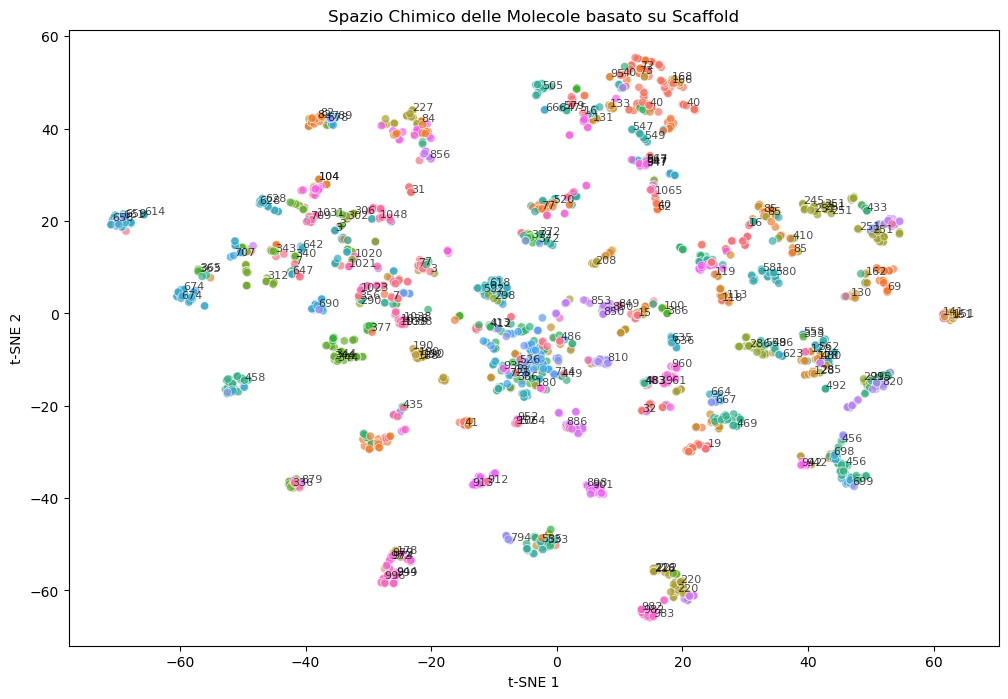

In [43]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="TSNE1", y="TSNE2", hue="Scaffold", palette=palette, data=df, alpha=0.7, legend=False)

for i, row in df.iterrows():
    if row["Molecule Name"] == "Osimertinib" or np.random.rand() < 0.08:  
        plt.text(row["TSNE1"], row["TSNE2"], row["Cluster_ID"], fontsize=8, alpha=0.7)

plt.title("Spazio Chimico delle Molecole basato su Scaffold")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

## formatting clustered files 

In [7]:
df=pd.read_csv("/home/federica/LAB2/egfr_35/filtered_act/clustered_dataset.csv")

In [8]:
df.columns
df = df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type','Standard Relation', 'Standard Value', 'Standard Units', 'Document ChEMBL ID']]
df['Smiles (RDKit Mol)']=''
df.columns

Index(['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation',
       'Standard Value', 'Standard Units', 'Document ChEMBL ID',
       'Smiles (RDKit Mol)'],
      dtype='object')

In [ ]:
df.to_csv("/home/federica/LAB2/egfr_qsar/egfr.csv", index=False)

## Cluster su EGFR
Conto le molecole che fanno parte di uno stesso cluster su tutto egfr

In [ ]:
cluster= pd.read_csv('/home/federica/LAB2/egfr_35/filtered_act/clustered_dataset.csv')
cluster_counts = cluster.groupby('Cluster_ID').size().to_dict()

In [ ]:
cluster_counts_df = pd.DataFrame(list(cluster_counts.items()), columns=['Cluster_ID', 'Count'])
cluster_counts_df.to_csv('/home/federica/LAB2/egfr_35/filtered_act/cluster_counts.csv', index=False, sep=',')

## file cluster

In [15]:
f=pd.read_csv("/home/federica/LAB2/egfr_35/filtered_act/clustered_dataset.csv")
df = f[f['Cluster_ID'] == 618]
df = df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type','Standard Relation', 'Standard Value', 'Standard Units', 'Document ChEMBL ID']]
df['Smiles (RDKit Mol)']=''
df.to_csv("/home/federica/LAB2/egfr_qsar/cluster_618.csv", index=False)